## Norms of filters

1) Do all filters in the same group have the same norm? Plot norms of filter groups.

2) How strongly are similar filters connected to the next layer? Scatter plots -- 
    (a) norm_fc1 vs norm_fc2

3) **[TODO]** Do duplicate filters have low norm compared to unique filters? filter norm vs. cc_size


In [3]:
import os
import torch
import torchvision
import torch.optim as optim
# from torch.optim.lr_scheduler import StepLR
import json
import numpy as np
import matplotlib as plt
from vis_utils import *
from model_def import *
from model_train import *
from net_reduce import *
import numpy as np


% matplotlib inline

plt.rcParams.update({'font.size': 20})


### Norms within a filter group

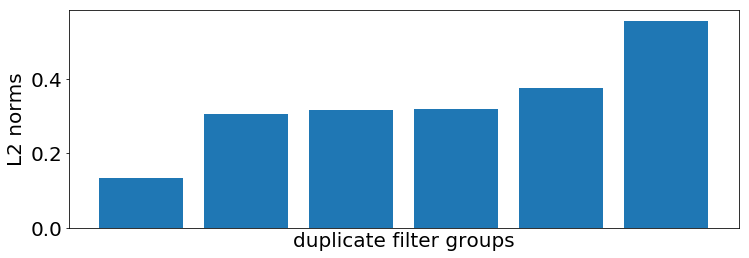

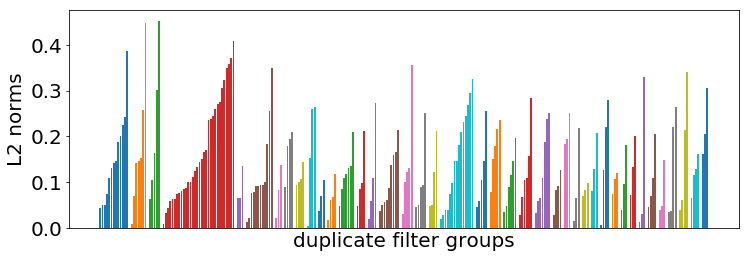

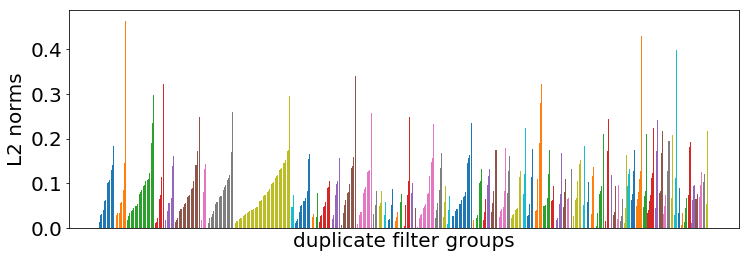

In [4]:
# change settings here:
numFilter = [100, 500, 1000]
expRoot = 'cifar-mlp-v1_w1-'
LAYER_CURR = 'fc1'
LAYER_NEXT = 'fc2'
SIMIL_THRESH = 0.9

outDir = os.path.join('./data', 'figures', 'mlp-v1-simil')
if not os.path.exists(outDir):
    os.makedirs(outDir)

for idx,i in enumerate(numFilter):
    
    # load network
    expFolder = os.path.join('data', expRoot+str(i))
    modelPath = os.path.join(expFolder, 'net-trained.dat')
    w1 = i
    w2 = 100
    net = MLP(input_dim=3072, fc1_dim=w1, fc2_dim=w2)
    net.load_state_dict(torch.load(modelPath))
    
    # filters sorted by norm
    layer_curr_weights = get_param(net, LAYER_CURR+'.weight').cpu()
    w_fc1_norms = np.asarray([torch.norm(w.view(-1), p=2) for w in layer_curr_weights])
    norms_sort_indices = np.argsort(w_fc1_norms)
    curr_weights_sorted = layer_curr_weights[norms_sort_indices,:]
    
    _, similMat = weightCovar(curr_weights_sorted)
    similMat = similMat.numpy()
    adj_mat = np.greater(similMat, SIMIL_THRESH)
    cc_list, n_comps = get_adjmat_conn_comp(adj_mat)
    
    # permute filters by index in cc_list
    cc_list_flat = np.concatenate(cc_list)
    w_fc1_norms = np.asarray(w_fc1_norms)
    w_fc1_norms_permuted = w_fc1_norms[cc_list_flat]
    
    # extend figure size horizontally
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 12
    fig_size[1] = 4
    plt.rcParams["figure.figsize"] = fig_size
    f = plt.figure()
    b = 0
    for i, filter_idx in enumerate(cc_list):
        if len(filter_idx) > 2:
            c = b + len(filter_idx)
            plt.bar(np.arange(b,c,1), np.sort(w_fc1_norms[filter_idx]))
            b = c + 1
        
#         if i > 100:
#             break
    plt.xticks([])
    plt.xlabel('duplicate filter groups')
    plt.ylabel('L2 norms')
    f.savefig(os.path.join(expFolder,'duplicate-filter-norms.png'))

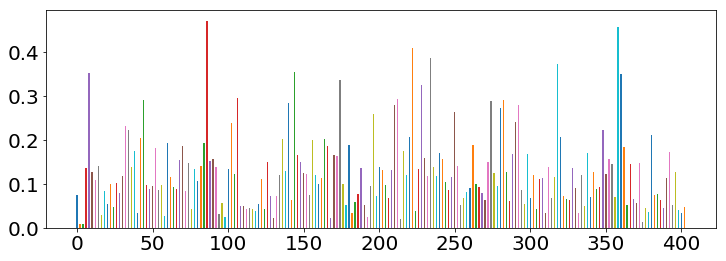

In [11]:
# norms of singleton (unique) filters
f = plt.figure()
b = 0
for i, filter_idx in enumerate(cc_list):
    if len(filter_idx) == 1:
        c = b + len(filter_idx)
        plt.bar(np.arange(b,c,1), np.sort(w_fc1_norms[filter_idx]))
        b = c + 1

### Norms of fc1 and fc2

In [5]:
# change settings here:
numFilter = [100,500,1000]
expRoot = 'cifar-mlp-v1_w1-'
LAYER_CURR = 'fc1'
LAYER_NEXT = 'fc2'
SIMIL_THRESH = 0.9

In [6]:
layer_curr_weights = get_param(net, LAYER_CURR+'.weight').cpu()
layer_next_weights = get_param(net, LAYER_NEXT+'.weight').cpu()

print layer_curr_weights.size()
print layer_next_weights.size()

torch.Size([1000, 3072])
torch.Size([100, 1000])


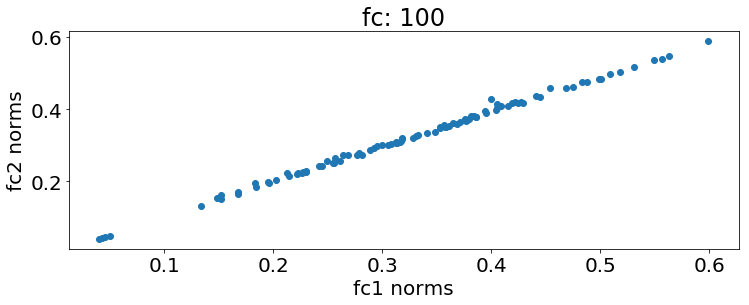

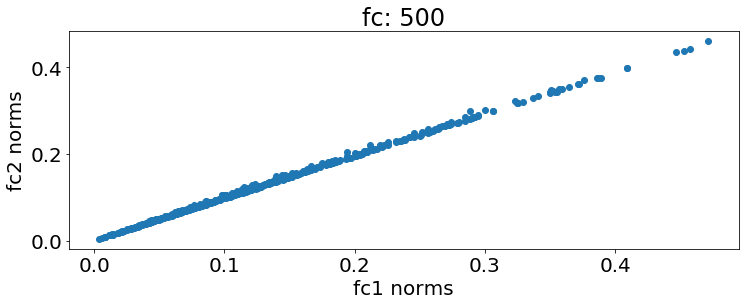

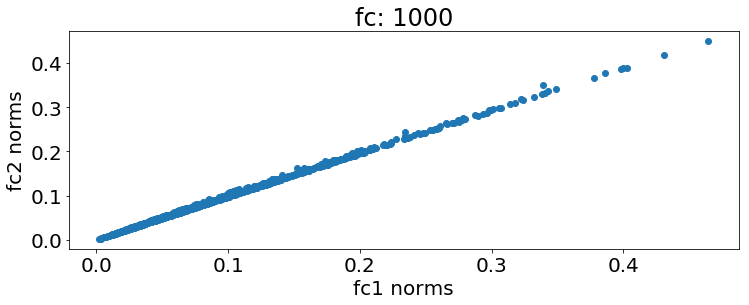

In [7]:
for idx,i in enumerate(numFilter):
    
    # load network
    expFolder = os.path.join('data', expRoot+str(i))
    modelPath = os.path.join(expFolder, 'net-trained.dat')
    w1 = i
    w2 = 100
    net = MLP(input_dim=3072, fc1_dim=w1, fc2_dim=w2)
    net.load_state_dict(torch.load(modelPath))
    
    
    # calc fc1 L2-norms
    layer_curr_weights = get_param(net, LAYER_CURR+'.weight').cpu()
    w_fc1_norms = [torch.norm(w.view(-1), p=2) for w in layer_curr_weights]
    
    
    # calc fc2 L2-norms
    layer_next_weights = get_param(net, LAYER_NEXT+'.weight').cpu()
    w_fc2_norms = [torch.norm(w.view(-1), p=2) for w in layer_next_weights.transpose(1,0).contiguous()]
    
    f = plt.figure()
    plt.plot(w_fc1_norms, w_fc2_norms, 'o')
    plt.xlabel('fc1 norms')
    plt.ylabel('fc2 norms')
    plt.title('fc: %d' % i)
    f.savefig(os.path.join(expFolder,'filter-norms-corr.png'))

In [ ]:
# change settings here:
numFilter = [500]
expRoot = 'cifar-mlp-v1_w1-'
LAYER_CURR = 'fc1'
LAYER_NEXT = 'fc2'
SIMIL_THRESH = 0.9

for idx,i in enumerate(numFilter):
    
    # load network
    expFolder = os.path.join('data', expRoot+str(i))
    modelPath = os.path.join(expFolder, 'net-trained.dat')
    w1 = i
    w2 = 100
    net = MLP(input_dim=3072, fc1_dim=w1, fc2_dim=w2)
    net.load_state_dict(torch.load(modelPath))
    
    # filter norm
    layer_curr_weights = get_param(net, LAYER_CURR+'.weight').cpu()
    w_fc1_norms = np.asarray([torch.norm(w.view(-1), p=2) for w in layer_curr_weights])
    
    _, similMat = weightCovar(layer_curr_weights)
    similMat = similMat.numpy()
    adj_mat = np.greater(similMat, SIMIL_THRESH)
    cc_list, n_comps = get_adjmat_conn_comp(adj_mat)
    
    # permute filters by index in cc_list
    cc_list_flat = np.concatenate(cc_list)
    w_fc1_norms = np.asarray(w_fc1_norms)
    
    
    f = plt.figure()
    
    for i, filter_idx in enumerate(cc_list):
        
        

    plt.xticks([])
    plt.xlabel('duplicate filter groups')
    plt.ylabel('L2 norms')
    # f.savefig(os.path.join(expFolder,'duplicate-filter-norms.png'))

In [ ]:
f = plt.figure()

num_filters = np.asarray([64, 192, 384, 256, 256], dtype=np.float32)
filter_names = ['conv1', 'conv2', 'conv3', 'conv4', 'conv5']

# conv1
filters_pruned = np.asarray([41.0, 30.0, 13.0, 1.0, 0.0, 0.0], dtype=np.float32)
acc_dup = [23.0, 52.0, 70.0, 76.0, 77.0, 77.0]
compression = filters_pruned/num_filters[0] * 100.0
plt.plot(compression, acc_dup, 'o-', label=filter_names[0])

# conv2
filters_pruned = np.asarray([117, 57, 6, 0, 0, 0],dtype=np.float32)
acc_dup = [49, 70, 76, 77, 77, 77]
compression = filters_pruned/num_filters[1] * 100.0
plt.plot(compression, acc_dup, 'o-', label=filter_names[1])

# conv3
filters_pruned = np.asarray([71, 19, 1, 0, 0, 0],dtype=np.float32)
acc_dup = [74, 76, 77, 77, 77, 77]
compression = filters_pruned/num_filters[2] * 100.0
plt.plot(compression, acc_dup, 'o-', label=filter_names[2])

# conv4
filters_pruned = np.asarray([13, 1, 0, 0, 0, 0],dtype=np.float32)
acc_dup = [77, 77, 77, 77, 77, 77]
compression = filters_pruned/num_filters[3] * 100.0
plt.plot(compression, acc_dup, 'o-', label=filter_names[3])

# # conv5
# filters_pruned = np.asarray([242, 236, 79, 4, 0, 0],dtype=np.float32)
# acc_dup = [9, 18, 75, 77, 77, 77]
# compression = filters_pruned/num_filters[4] * 100.0
# plt.plot(compression, acc_dup, 'o-', label=filter_names[4])

major_ticks = np.arange(20, 91, 20)
plt.yticks(major_ticks)
plt.xlabel('Filters pruned (%)')
plt.ylabel('Test accuracy (%)')
plt.legend(loc="lower left")

f.savefig(os.path.join('data', 'figures','alexnet-filter-prune-acc.pdf'), \
         bbox_inches='tight')
f.savefig(os.path.join('data', 'figures','alexnet-filter-prune-acc.png'), \
         bbox_inches='tight')

In [5]:
compression

array([ 0.,  0.,  0.,  0.,  0.,  0.])